# Machine Learning With the MNIST HandwritingDataset
---
Today we're going to do some machine learning in python. For those that would like to use what you learn here and go deeper into machine learning, the frameworks and libraries we will be using are


1.   numpy
2.   scikit-learn
3.   matplotlib
4.   pytorch
5.   opencv-python

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import torch.optim as optim
import torch
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import accuracy_score

# Next we're going to load our data
---
We can simply load the data from pytorch's datasets

In [2]:
# Load our datasets from pytorch
train = torchvision.datasets.MNIST(root='/imgs',train=True,download=True)
test = torchvision.datasets.MNIST(root='/imgs',train=False,download=True)

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /imgs/MNIST/raw/train-images-idx3-ubyte.gz to /imgs/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /imgs/MNIST/raw/train-labels-idx1-ubyte.gz to /imgs/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting /imgs/MNIST/raw/t10k-images-idx3-ubyte.gz to /imgs/MNIST/raw




Extracting /imgs/MNIST/raw/t10k-labels-idx1-ubyte.gz to /imgs/MNIST/raw

Processing...
Done!


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


7


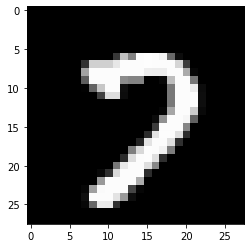

In [5]:
# Initialize our empty lists to add our data to them
x_train, y_train,x_test,y_test = [],[],[],[]
# Go through the training set and add the data to x_train and labels to y_train.
# Also normalize the data (may not be necessary in this case)
for data in train:
  y_train.append(data[1])
  img = data[0]
  img = ((img-np.mean(img))/np.std(img))
  x_train.append(img)
# Go through the test set and add the data to x_test and labels to y_test.
# Also normalize the data (may not be necessary in this case)
for data in test:
  y_test.append(data[1])
  img = data[0]
  img = ((img-np.mean(img))/np.std(img))
  x_test.append(img)

#Randomly display an image from the training set just to visualize our data
i = np.random.randint(0,len(x_train))
print(y_train[i])
plt.figure
plt.imshow(x_train[i], 'gray')
plt.show()

# Data Preparation
---
We're going to preprocess our data for our machine learning model

In [7]:
# Apply normalization on our data to zero center it
x_train = x_train-np.mean(x_train)

# Define our model's parameters (784 in features, 10 out features, 400 neurons in hidden layer)
imgSize = (28,28)
batchSize = 100
inFeatures,outFeatures,hidden = imgSize[0]*imgSize[1],len(set(y_train)),400 


In [10]:
# Make batches of data and labels
def make_batches(in_data,in_labels,imgSize,batchSize=100,color= False,shuffle = False):

  # If the image is in color, we'll have to account for the R,G,B, channels
  channels = 1
  if color:
    channels = 3

  # Mainly for train data, shuffles the data around
  data,labels = in_data,in_labels
  if shuffle:
    shuffled = list(zip(in_data, in_labels))
    random.shuffle(shuffled)
    data, labels = zip(*shuffled)

  # Create batches of tensors
  batch_data = []
  batch_labels = []
  for i in range(int(len(data) / batchSize)):
    minibatch_d = data[i*batchSize: (i+1)*batchSize]
    minibatch_d = np.reshape(minibatch_d, (batchSize, 1,imgSize[0], imgSize[1]))
    batch_data.append(torch.from_numpy(minibatch_d))
    minibatch_l = labels[i*batchSize: (i+1)*batchSize]
    batch_labels.append(torch.LongTensor(minibatch_l))
  return zip(batch_data,batch_labels)

#Call our function for making batches

train_data = list(make_batches(x_train,y_train,imgSize,batchSize,color = False,shuffle=True))
test_data = list(make_batches(x_test,y_test,imgSize,batchSize,))

# Building Our Model

---
Our next step is to create our neural network, train the network on our data, and test it on our test set



In [11]:
# Create a Feed Forward NN
class ANN(nn.Module):
    def __init__(self, input_size, hidden_size, out_size):
        super(ANN, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, out_size)
        self.relu = nn.ReLU()
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.relu(out)
        out = self.fc3(out)
        return out

In [12]:
# Initialize our model, loss function, and optimizer function
model = ANN(inFeatures,hidden,outFeatures).cuda()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(),lr = 0.001)

#Train for 100 epochs
for epoch in range(100):
  for i, data in enumerate(train_data, 0):
    # Change the shape of our data to match the input shape of the model
    inputs,labels = data
    inputs = Variable(inputs.view(-1,28*28))
    labels = Variable(labels)
    optimizer.zero_grad()
    # Forward Propagation
    out = model((inputs.float()).cuda())

    loss = criterion(out.cuda(), labels.cuda())
    # Backward Propagation
    loss.backward()

    optimizer.step()

In [13]:
# Results on the test set
test_labels = []
res = []
for i, data in enumerate(test_data,0):
  inputs, labels = data
  inputs = Variable(inputs.view(-1,28*28))
  labels = Variable(labels)
  outputs = model((inputs.float()).cuda())
  _,pred = torch.max(outputs, 1)
  test_labels = test_labels + labels.tolist()
  res = res + pred.tolist()
print(test_labels)
print(res)
print(accuracy_score(test_labels,res)*100)

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9, 0, 6, 9, 0, 1, 5, 9, 7, 3, 4, 9, 6, 6, 5, 4, 0, 7, 4, 0, 1, 3, 1, 3, 4, 7, 2, 7, 1, 2, 1, 1, 7, 4, 2, 3, 5, 1, 2, 4, 4, 6, 3, 5, 5, 6, 0, 4, 1, 9, 5, 7, 8, 9, 3, 7, 4, 6, 4, 3, 0, 7, 0, 2, 9, 1, 7, 3, 2, 9, 7, 7, 6, 2, 7, 8, 4, 7, 3, 6, 1, 3, 6, 9, 3, 1, 4, 1, 7, 6, 9, 6, 0, 5, 4, 9, 9, 2, 1, 9, 4, 8, 7, 3, 9, 7, 4, 4, 4, 9, 2, 5, 4, 7, 6, 7, 9, 0, 5, 8, 5, 6, 6, 5, 7, 8, 1, 0, 1, 6, 4, 6, 7, 3, 1, 7, 1, 8, 2, 0, 2, 9, 9, 5, 5, 1, 5, 6, 0, 3, 4, 4, 6, 5, 4, 6, 5, 4, 5, 1, 4, 4, 7, 2, 3, 2, 7, 1, 8, 1, 8, 1, 8, 5, 0, 8, 9, 2, 5, 0, 1, 1, 1, 0, 9, 0, 3, 1, 6, 4, 2, 3, 6, 1, 1, 1, 3, 9, 5, 2, 9, 4, 5, 9, 3, 9, 0, 3, 6, 5, 5, 7, 2, 2, 7, 1, 2, 8, 4, 1, 7, 3, 3, 8, 8, 7, 9, 2, 2, 4, 1, 5, 9, 8, 7, 2, 3, 0, 4, 4, 2, 4, 1, 9, 5, 7, 7, 2, 8, 2, 6, 8, 5, 7, 7, 9, 1, 8, 1, 8, 0, 3, 0, 1, 9, 9, 4, 1, 8, 2, 1, 2, 9, 7, 5, 9, 2, 6, 4, 1, 5, 8, 2, 9, 2, 0, 4, 0, 0, 2, 8, 4, 7, 1, 2, 4, 0, 2, 7, 4, 3, 3, 0, 0, 3, 1, 9, 6, 5, 2, 5, 9, 2, 9, 3, 0, 4, 2, 0, 7, 1, 1, 2, 1, 